<a href="https://colab.research.google.com/github/DoraTheExploring/AFML/blob/master/notebooks/AFML_c2_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advances in Financial Machine Learning


Implementations of the code snippets from the book

## Get Data for Demo

In [2]:
%%capture
!wget https://raw.githubusercontent.com/chrisconlan/algorithmic-trading-with-python/1f615f488a3faa6274a701afccfcf977dfa83570/data/alternative_data/AWU.csv -O "awu_alt.csv"
!wget https://raw.githubusercontent.com/chrisconlan/algorithmic-trading-with-python/1f615f488a3faa6274a701afccfcf977dfa83570/data/eod/AWU.csv -O "awu_eod.csv"


In [3]:
!ls -ls

total 144
 24 -rw-r--r-- 1 root root  22773 May  4 18:13 awu_alt.csv
116 -rw-r--r-- 1 root root 115288 May  4 18:13 awu_eod.csv
  4 drwxr-xr-x 1 root root   4096 Apr 21 13:39 sample_data


### Visualise Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
awu_eod = pd.read_csv('awu_eod.csv')
awu_alt = pd.read_csv('awu_alt.csv')

In [ ]:
awu_eod.head()

,date,open,close,low,high,volume
0,2010-01-04,193.94,191.70,190.63,195.51,968029
1,2010-01-05,191.02,188.17,186.99,192.42,1427075
2,2010-01-06,187.17,186.50,185.10,190.07,879014
3,2010-01-07,185.03,185.19,183.63,186.64,1003719
4,2010-01-08,184.67,187.02,182.78,187.27,804716


In [ ]:
awu_alt.head()

,date,value
0,2015-03-31,23305.0
1,2015-04-01,20640.0
2,2015-04-02,23522.0
3,2015-04-06,24449.0
4,2015-04-07,21489.0


In [ ]:
awu_eod.index = pd.to_datetime(awu_eod.date)
awu_alt.index = pd.to_datetime(awu_alt.date)

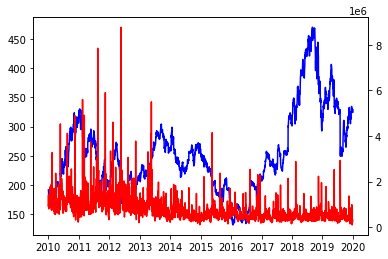

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(awu_eod.index, awu_eod.close, 'b-')
ax2.plot(awu_eod.index, awu_eod.volume, 'r-')

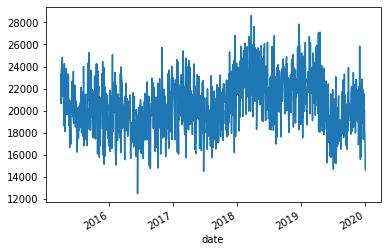

In [ ]:
awu_alt.value.plot()

## Chapter 2: Financial Data Structures

In [ ]:
## Snippet 2.1: PCA Weights from Risk Distribution R

def pcaWeights(cov, riskDist=None, riskTarget=1.):
  # Following the risk allo distribution, match riskTarget
  eVal, eVec = np.linalg.eigh(cov) # must be Hermitian
  indices = eVal.argsort()[::-1]# args for sorting eVal desc
  eVal, eVec = eVal[indices], eVec[:, indices]
  if riskDist is None:
    riskDist=np.zeros(cov.shape[0])
    riskDist[-1]=1
  loads = riskTarget* (riskDist/eVal)**.5
  wghts = np.dot(eVec, np.reshape(loads, (-1,1)))
  #ctr = loads(/riskTarget)**2*eVal #verify riskDist
  return wghts

In [ ]:
## Snippet 2.2: Form GAPS series, detract it from prices

In [ ]:
## Snippet 2.3: Non-negative rolled price series

In [ ]:
## Snippet 2.4: The symmetric cusum filter
"""
Quality control method designed to detect a shift in the mean value of a measure quantity away from a target value.

"""

def getCusumEvents(raw, threshold):
  events, pos, neg = [], 0, 0
  diff = raw.diff()
  for ii in diff.index[1:]:
    pos, neg = max(0, pos+diff.loc[ii]), min(0, neg+diff.loc[ii])
    if neg < -threshold:
      neg=0; events.append(ii)
    elif pos> threshold:
      pos=0; events.append(ii)
  return(pd.DatetimeIndex(events))


def getCusumData(raw, threshold):
  data, pos, neg = [], 0, 0
  data.append([pos, neg])
  diff = raw.diff()
  for ii in diff.index[1:]:
    pos, neg = max(0, pos+diff.loc[ii]), min(0, neg+diff.loc[ii])
    if neg < -threshold:
      neg=0
    elif pos> threshold:
      pos=0; 
    data.append([pos, neg])
  return(pd.DataFrame(data, columns=['pos', 'neg']))


In [ ]:
threshold = 0.3
series = awu_alt.value
series_log = np.log(series)
events = getCusumEvents(series_log, threshold)
print(len(series))
print(len(events))
print(events[:5])

1198
147
DatetimeIndex(['2015-04-23', '2015-05-20', '2015-06-02', '2015-07-02',
               '2015-07-24'],
              dtype='datetime64[ns]', freq=None)


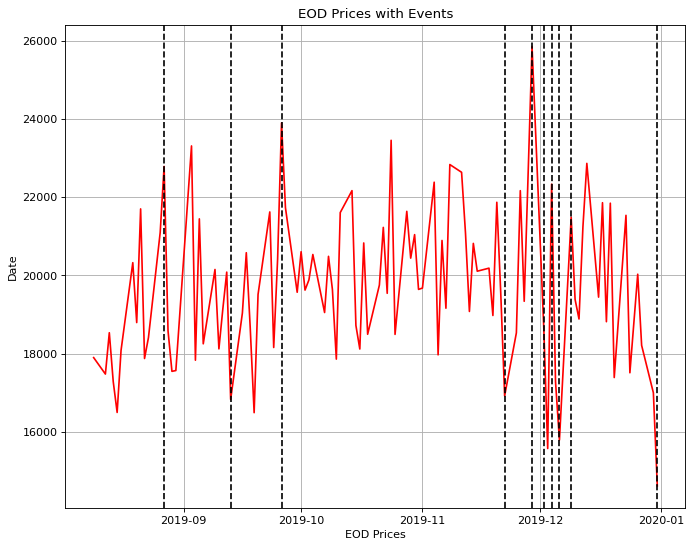

In [ ]:
series_sub = series[-100:]
events_sub = events[events.slice_indexer(series_sub.index.min())]

plt.figure(figsize=(10, 8), dpi=80)
plt.plot(series_sub, 'r-')
for dte in events_sub.to_pydatetime():
    plt.axvline(x=dte, color='k', linestyle='--')
plt.xlabel('EOD Prices')
plt.ylabel('Date')
plt.title('EOD Prices with Events')
plt.grid(True)
plt.show()

                 pos       neg
date                          
2015-03-31  0.000000  0.000000
2015-04-01  0.000000 -0.121437
2015-04-02  0.130705  0.000000
2015-04-06  0.169358  0.000000
2015-04-07  0.040310 -0.129048


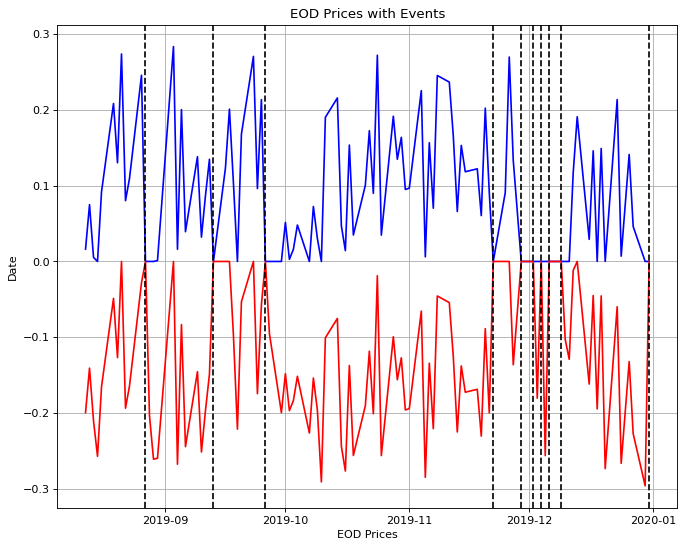

In [ ]:
cusumData = getCusumData(series_log, threshold)
cusumData.index=series_log.index
print(cusumData.head())

cusumData_sub = cusumData.loc[cusumData.index>series_sub.index.min()]

plt.figure(figsize=(10, 8), dpi=80)
plt.plot(cusumData_sub.pos, 'b-')
plt.plot(cusumData_sub.neg, 'r-')
for dte in events_sub.to_pydatetime():
    plt.axvline(x=dte, color='k', linestyle='--')
plt.xlabel('EOD Prices')
plt.ylabel('Date')
plt.title('EOD Prices with Events')
plt.grid(True)
plt.show()

## Chapter 3: Labeling

In [ ]:
## Snippet 3.1: Daily Volatility Estimates

def getDailyVol(close, span=100):
  df = close.index.searchsorted(close.index-pd.Timedelta(days=1))
  df = df[df>0]
  df = pd.Series(close.index[df-1], index=close.index[close.shape[0]-df.shape[0]:])
  df = close.loc[df.index]/ close.loc[df.values].values-1
  df = df.ewm(span=span).std()
  return df

def getDailyVol(close,span0=100):
    # daily vol reindexed to close
    df0=close.index.searchsorted(close.index-pd.Timedelta(days=1))
    df0=df0[df0>0]   
    df0=(pd.Series(close.index[df0-1], 
                   index=close.index[close.shape[0]-df0.shape[0]:]))   
    try:
        df0=close.loc[df0.index]/close.loc[df0.values].values-1 # daily rets
    except Exception as e:
        print(f'error: {e}\nplease confirm no duplicate indices')
    df0=df0.ewm(span=span0).std().rename('dailyVol')
    return df0

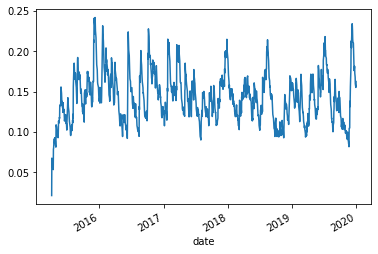

In [ ]:
getDailyVol(series, span=20).plot()

In [ ]:
## Snippet 3.2: Tripple-Barrier Labelling method

def triple_barrier(close, events, pts):#, molecule
  events_ = events#.loc[molecule]
  out = events_[['t1']].copy(deep=True)
  if pts[0]>0: pt=pts[0]*events_['target']
  else: pt = pd.Series(index=events.index)
  if pts[1]>0: s1=-pts[1]*events_['target']
  else: s1 = pd.Series(index=events.index)
  for loc, t1 in events_['t1'].fillna(close.index[-1].iteritems()):
    df=close[loc:t1]
    df=(df/close[loc]-1)*events_.at[loc, 'side']
    out.loc[loc, 's1']=df[df<s1[loc]].index.min()
    out.loc[loc, 'pt']=df[df>pt[loc]].index.min()
  return out


In [ ]:
## Snippet 3.3: getting time of first touch

def getEvents(close, tevents, pts, target, minRet, numThreads, t1=False):
  target=target.loc[tevents]
  target=target[target>minRet]
  print('a')
  if t1 is False: t1=pd.Series(pd.NaT, index=tevents)
  print('b')
  side_=pd.Series(1., index=target.index)
  print('c')
  events=pd.concat({'t1':t1, 'target':target, 'side':side_}, \
                   axis=1).dropna(subject=['target'])
  print('d')
  df=mpPandasObj(func=triple_barrier, pdObj=('molecule', events.index), \
                 numThreads=numThreads, close=close, events=events, pts=[pts, pts])
  print('e')
  events['t1']=df.dropna(how='all').min(axis=1)
  events=events.drop('side', axis=1)
  return events


In [ ]:
## Snippet 3.4: Adding vertical barrier

numDays=1
t1 = close.index.searchsorted(tevents+pd.Timedelta(days=numDays))
t1 = t1[t1<close.shape[0]]
t1 = pd.Series(close.index[t1], index=tevents[:t1.shape[0]])


In [ ]:
## Snippet 3.5: Labeling for side and size

def getBins(events, close):
  events_=events.dropna(subset=['t1'])
  px = events_.index.union(events_['t1'].values).drop_duplicates()
  px = close.reindex(px, method='bfill')
  out = pd.DataFrame(index=events_.index)
  out['ret']=px.loc[events_['t1'].values].values/px.loc[events_.index]-1
  out['bin']=np.sign(out['ret'])
  return out
  

In [ ]:
## Snippet 3.6: Expanding getEvents to incorp meta-labeling

def getEvents(close, tevents, pts, target, minRet, numThreads, t1=False, side=None):
  target=target.loc[tevents]
  target=target[target>minRet]
  if t1 is False: t1=pd.Series(pd.NaT, index=tevents)
  if side is None: side_, pts_=pd.Series(1., index=target.index), [pts[0], pts[0]]
  else: side_, pts=side.loc[target.index], pts[:2]
  events=pd.concat({'t1':t1, 'target':target, 'side':side_}, \
                   axis=1).dropna(subject=['target'])
  df=mpPandasObj(func=triple_barrier, pdObj=('molecule', events.index), \
                 numThreads=numThreads, close=close, events=events, pts=[pts, pts])
  events['t1']=df.dropna(how='all').min(axis=1)
  if side is None: events=events.drop('side', axis=1)
  return events


In [ ]:
## Snippet 3.7: Expanding getBins to incorp meta-labeling

def getBins(events, close):
    '''
    Compute event's outcome (including side information, if provided).
    events is a DataFrame where:
    -events.index is event's starttime
    -events['t1'] is event's endtime
    -events['trgt'] is event's target
    -events['side'] (optional) implies the algo's position side
    Case 1: ('side' not in events): bin in (-1,1) <-label by price action
    Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    '''
    #1) prices aligned with events
    events_=events.dropna(subset=['t1'])
    px=events_.index.union(events_['t1'].values).drop_duplicates()
    px=close.reindex(px,method='bfill')
    #2) create out object
    out=pd.DataFrame(index=events_.index)
    out['ret']=px.loc[events_['t1'].values].values/px.loc[events_.index]-1
    if 'side' in events_:out['ret']*=events_['side'] # meta-labeling
    out['bin']=np.sign(out['ret'])
    if 'side' in events_:out.loc[out['ret']<=0,'bin']=0 # meta-labeling
    return out

labels = getBins(events, close)
print(labels)
print(labels.bin.value_counts())

In [ ]:
## Snippet 3.8 Dropping under-populated labels

def dropLabels(events, minPct=.05):
    # apply weights, drop labels with insufficient examples
    while True:
      df0=events['bin'].value_counts(normalize=True)
      if df0.min()>minPct or df0.shape[0]<3:break
      print('dropped label: ', df0.argmin(),df0.min())
      events=events[events['bin']!=df0.argmin()]
    return events


## Chapter 4: Sample Weights

In [ ]:
## Snippet 4.1: Estimating uniqueness of a label

In [ ]:
## Snippet 4.2: Estimating the average uniqueness of a label

In [ ]:
## Snippet 4.3: Build an indicator matrix

In [ ]:
## Snippet 4.4: Compute average uniqueness

In [ ]:
## Snippet 4.5: Return sample from sequential bootstrap

In [ ]:
## Snippet 4.6: Example of sequential bootstrap

In [ ]:
## Snippet 4.7: Generating random t1 series

In [ ]:
## Snippet 4.8: Uniqueness from standard and sequential bootstraps

In [ ]:
## Snippet 4.9: Multi-threaded monte-carlo 

In [ ]:
## Snippet 4.10 Determination of sample weight by absolute return attribution

In [ ]:
## Snippet 4.11: Implementation of time-decay factors

## Chapter 5: Fractionally Differentiated Features

In [ ]:
## Snippet 5.1: Weighting function

In [ ]:
## Snippet 5.2: Standard fracdiff (expanding window)

In [ ]:
## Snippet 5.3: The new fixed-width window fracdiff method

In [ ]:
## Snippet 5.4: Finding the minimum D value that passes the ADF test

### Crossover with Algo Python

In [ ]:
def calculate_non_uniform_lagged_change(series: pd.Series, n_days: int):
    """
    Use pd.Series.searchsorted to measure the lagged change in a non-uniformly 
    spaced time series over n_days of calendar time. 
    """
    # Get mapping from now to n_days ago at every point
    _timedelta: pd.Timedelta = pd.Timedelta(days=n_days)
    _idx: pd.Series = series.index.searchsorted(series.index - _timedelta)
    _idx = _idx[_idx > 0]
    # Get the last len(series) - n_days values
    _series = series.iloc[-_idx.shape[0]:]
    # Build a padding of NA values
    _pad_length = series.shape[0] - _idx.shape[0]
    _na_pad = pd.Series(None, index=series.index[:_pad_length])
    # Get the corresonding lagged values
    _lagged_series = series.iloc[_idx]
    # Measure the difference
    _diff = pd.Series(_series.values-_lagged_series.values, index=_series.index)
    return pd.concat([_na_pad, _diff])

def calculate_cusum_events(series: pd.Series, 
    filter_threshold: float) -> pd.DatetimeIndex:
    """
    Calculate symmetric cusum filter and corresponding events
    """
    event_dates = list()
    s_up = 0
    s_down = 0
    for date, price in series.items():
        s_up = max(0, s_up + price)
        s_down = min(0, s_down + price)
        if s_up > filter_threshold:
            s_up = 0
            event_dates.append(date)
        elif s_down < -filter_threshold:
            s_down = 0
            event_dates.append(date)
    return pd.DatetimeIndex(event_dates)

from typing import Tuple


def calculate_events_for_revenue_series(series: pd.Series, 
    filter_threshold: float, lookback: int=365) -> pd.DatetimeIndex:
    """
    Calculate the symmetric cusum filter to generate events on YoY changes in 
    the log revenue series
    """
    series = np.log(series)
    series = calculate_non_uniform_lagged_change(series, lookback)
    return calculate_cusum_events(series, filter_threshold)


def calculate_events(revenue_series: pd.Series, threshold):
    return calculate_events_for_revenue_series(
        revenue_series,
        filter_threshold=threshold,
        lookback=1,
    )


def compute_triple_barrier_labels(
    price_series: pd.Series, 
    event_index: pd.Series, 
    time_delta_days: int, 
    upper_delta: float=None, 
    lower_delta: float=None, 
    vol_span: int=20, 
    upper_z: float=None,
    lower_z: float=None,
    upper_label: int=1, 
    lower_label: int=-1) -> Tuple[pd.Series, pd.Series]:
    """
    Calculate event labels according to the triple-barrier method. 
    Return a series with both the original events and the labels. Labels 1, 0, 
    and -1 correspond to upper barrier breach, vertical barrier breach, and 
    lower barrier breach, respectively. 
    Also return series where the index is the start date of the label and the 
    values are the end dates of the label.
    """

    timedelta = pd.Timedelta(days=time_delta_days)
    series = pd.Series(np.log(price_series.values), index=price_series.index)

    # A list with elements of {-1, 0, 1} indicating the outcome of the events
    labels = list()
    label_dates = list()

    if upper_z or lower_z:
        volatility = series.ewm(span=vol_span).std()
        volatility *= np.sqrt(time_delta_days / vol_span)

    for event_date in event_index:
        date_barrier = event_date + timedelta

        start_price = series.loc[event_date]
        log_returns = series.loc[event_date:date_barrier] - start_price

        # First element of tuple is 1 or -1 indicating upper or lower barrier
        # Second element of tuple is first date when barrier was crossed
        candidates: List[Tuple[int, pd.Timestamp]] = list()

        # Add the first upper or lower date to candidates
        if upper_delta:
            _date = log_returns[log_returns > upper_delta].first_valid_index()
            if _date:
                candidates.append((upper_label, _date))
    
        if lower_delta:
            _date = log_returns[log_returns < lower_delta].first_valid_index()
            if _date:
                candidates.append((lower_label, _date))

        # Add the first upper_z and lower_z to candidates
        if upper_z:
            upper_barrier = upper_z * volatility[event_date]
            _date = log_returns[log_returns > upper_barrier].first_valid_index()
            if _date:
                candidates.append((upper_label, _date))

        if lower_z:
            lower_barrier = lower_z * volatility[event_date]
            _date = log_returns[log_returns < lower_barrier].first_valid_index()
            if _date:
                candidates.append((lower_label, _date))

        if candidates:
            # If any candidates, return label for first date
            label, label_date = min(candidates, key=lambda x: x[1])
        else:
            # If there were no candidates, time barrier was touched
            label, label_date = 0, date_barrier

        labels.append(label)
        label_dates.append(label_date)

    label_series = pd.Series(labels, index=event_index)
    event_spans = pd.Series(label_dates, index=event_index)

    return label_series, event_spans


def calculate_labels(price_series, event_index, label_threshold, time_delta_days) -> Tuple[pd.Series, pd.Series]:
    """
    Calculate labels based on the triple barrier method. Return a series of 
    event labels index by event start date, and return a series of event end 
    dates indexed by event start date.
    """

    # Remove event that don't have a proper chance to materialize
    time_delta_days = time_delta_days
    max_date = price_series.index.max()
    cutoff = max_date - pd.Timedelta(days=time_delta_days)
    event_index = event_index[event_index <= cutoff]

    # Use triple barrier method
    event_labels, event_spans = compute_triple_barrier_labels(
        price_series,
        event_index,
        time_delta_days=time_delta_days,
        upper_z = label_threshold,
        lower_z = -label_threshold,
    )

    return event_labels, event_spans


### Questions

In [ ]:
series = awu_alt.value
close = series

threshold = close.std()
tevents = getCusumEvents(close, threshold)

numDays=1
t1 = close.index.searchsorted(tevents+pd.Timedelta(days=numDays))
t1 = t1[t1<close.shape[0]]
t1 = pd.Series(close.index[t1], index=tevents[:t1.shape[0]])


In [ ]:
from tqdm import tqdm, tqdm_notebook

In [ ]:
dailyVol = getDailyVol(close, span0=100)

In [ ]:
# Get events, labels, weights, and features

dailyVol=getDailyVol(close_alt)

event_index = calculate_events(awu_alt.value, threshold=dailyVol.mean()*2)
event_labels, event_spans = calculate_labels(close, event_index, label_threshold=1, time_delta_days=1)

print(close.shape)
print(close_alt.shape)
print(event_index.shape)
print(event_labels.shape)
print(event_spans.shape)
print(event_labels.value_counts())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


(1737,)
(1737,)
(174,)
(174,)
(174,)
 1    62
 0    60
-1    52
dtype: int64


In [ ]:
def addVerticalBarrier(tEvents, close, numDays=1):
    # get the index of the event in price series
    t1=close.index.searchsorted(tEvents+pd.Timedelta(days=numDays))
    # ensure the index is less than max length
    t1=t1[t1<close.shape[0]]
    # change to series, with index being the event, and lookforward being close date
    t1=(pd.Series(close.index[t1],index=tEvents[:t1.shape[0]]))
    return t1

def getEvents(close, tEvents, ptSl, trgt, minRet, numThreads, t1=False, side=None):
    #1) get target
    trgt = trgt.reindex(index = tEvents)
    trgt=trgt.loc[tEvents]
    print("Worked fine")
    #trgt=trgt[trgt>minRet] # minRet
    #2) get t1 (max holding period)
    if t1 is False:t1=pd.Series(pd.NaT, index=tEvents)
    #3) form events object, apply stop loss on t1
    if side is None:side_,ptSl_=pd.Series(1.,index=trgt.index), [ptSl[0],ptSl[0]]
    #else: side_,ptSl_=side.reindex(index=trgt.index).dropna(),ptSl[:2]
    else: side_,ptSl_=side.loc[trgt.index],ptSl[:2]
    events=(pd.concat({'t1':t1,'trgt':trgt,'side':side_}, axis=1)
            .dropna(subset=['trgt']))
    df0=mpPandasObj(func=applyPtSlOnT1,pdObj=('molecule',events.index),
                    numThreads=numThreads,close=close,events=events,
                    ptSl=ptSl_)
    events['t1']=df0.dropna(how='all').min(axis=1) # pd.min ignores nan
    if side is None:events=events.drop('side',axis=1)
    return events

def applyPtSlOnT1(close,events,ptSl,molecule):
     # apply stop loss/profit taking, if it takes place before t1 (end of event)
    events_=events.loc[molecule]
    out=events_[['t1']].copy(deep=True)
    if ptSl[0]>0: pt=ptSl[0]*events_['trgt']
    else: pt=pd.Series(index=events.index) # NaNs
    if ptSl[1]>0: sl=-ptSl[1]*events_['trgt']
    else: sl=pd.Series(index=events.index) # NaNs
    for loc,t1 in events_['t1'].fillna(close.index[-1]).iteritems():
        df0=close[loc:t1] # path prices
        df0=(df0/close[loc]-1)*events_.at[loc,'side'] # path returns
        out.loc[loc,'sl']=df0[df0<sl[loc]].index.min() # earliest stop loss
        out.loc[loc,'pt']=df0[df0>pt[loc]].index.min() # earliest profit taking
    return out   

def getDailyVol(close,span0=100):
    # daily vol reindexed to close
    df0=close.index.searchsorted(close.index-pd.Timedelta(days=1))
    df0=df0[df0>0]   
    df0=(pd.Series(close.index[df0-1], 
                   index=close.index[close.shape[0]-df0.shape[0]:]))   
    try:
        df0=close.loc[df0.index]/close.loc[df0.values].values-1 # daily rets
    except Exception as e:
        print(f'error: {e}\nplease confirm no duplicate indices')
    df0=df0.ewm(span=span0).std().rename('dailyVol')
    return df0


## standard cusum filter
def getTEvents(gRaw, h):
    tEvents, sPos, sNeg = [], 0, 0
    diff = np.log(gRaw).diff().dropna()
    for i in tqdm(diff.index[1:]):
        try:
            pos, neg = float(sPos+diff.loc[i]), float(sNeg+diff.loc[i])
        except Exception as e:
            print(e)
            print(sPos+diff.loc[i], type(sPos+diff.loc[i]))
            print(sNeg+diff.loc[i], type(sNeg+diff.loc[i]))
            break
        sPos, sNeg=max(0., pos), min(0., neg)
        if sNeg<-h:
            sNeg=0;tEvents.append(i)
        elif sPos>h:
            sPos=0;tEvents.append(i)
    return pd.DatetimeIndex(tEvents)

def mpPandasObj(func,pdObj,numThreads=24,mpBatches=1,linMols=True,**kargs):
    '''
    Parallelize jobs, return a dataframe or series
    + func: function to be parallelized. Returns a DataFrame
    + pdObj[0]: Name of argument used to pass the molecule
    + pdObj[1]: List of atoms that will be grouped into molecules
    + kwds: any other argument needed by func
    
    Example: df1=mpPandasObj(func,('molecule',df0.index),24,**kwds)
    '''
    import pandas as pd
    #if linMols:parts=linParts(len(argList[1]),numThreads*mpBatches)
    #else:parts=nestedParts(len(argList[1]),numThreads*mpBatches)
    if linMols:parts=linParts(len(pdObj[1]),numThreads*mpBatches)
    else:parts=nestedParts(len(pdObj[1]),numThreads*mpBatches)
    
    jobs=[]
    for i in range(1,len(parts)):
        job={pdObj[0]:pdObj[1][parts[i-1]:parts[i]],'func':func}
        job.update(kargs)
        jobs.append(job)
    if numThreads==1:out=processJobs_(jobs)
    else: out=processJobs(jobs,numThreads=numThreads)
    if isinstance(out[0],pd.DataFrame):df0=pd.DataFrame()
    elif isinstance(out[0],pd.Series):df0=pd.Series()
    else:return out
    for i in out:df0=df0.append(i)
    df0=df0.sort_index()
    return df0


def linParts(numAtoms,numThreads):
    # partition of atoms with a single loop
    parts=np.linspace(0,numAtoms,min(numThreads,numAtoms)+1)
    parts=np.ceil(parts).astype(int)
    return parts

def processJobs_(jobs):
    # Run jobs sequentially, for debugging
    out=[]
    for job in jobs:
        out_=expandCall(job)
        out.append(out_)
    return out


def expandCall(kargs):
    # Expand the arguments of a callback function, kargs['func']
    func=kargs['func']
    del kargs['func']
    out=func(**kargs)
    return out   

In [ ]:
## CHECK VALID COMPARISON BETWEEN TWO IMPLEMENTATIONS

## standard cusum filter
def getTEvents(gRaw, h):
    tEvents, sPos, sNeg = [], 0, 0
    #diff = gRaw.diff().dropna()
    _idx = gRaw.index.searchsorted(gRaw.index - pd.Timedelta(days=1))
    diff = np.log(gRaw).diff()#.dropna()
    diff = diff[_idx>0]
    for i in tqdm(diff.index[1:]):
        pos, neg = float(sPos+diff.loc[i]), float(sNeg+diff.loc[i])
        sPos, sNeg=max(0., pos), min(0., neg)
        if sPos>h:
            sPos=0;tEvents.append(i)
        elif sNeg<-h:
            sNeg=0;tEvents.append(i)
    return pd.DatetimeIndex(tEvents), diff]


def calculate_non_uniform_lagged_change(series: pd.Series, n_days: int):
    """
    Use pd.Series.searchsorted to measure the lagged change in a non-uniformly 
    spaced time series over n_days of calendar time. 
    """
    # Get mapping from now to n_days ago at every point
    _timedelta: pd.Timedelta = pd.Timedelta(days=n_days)
    _idx: pd.Series = series.index.searchsorted(series.index - _timedelta)
    _idx = _idx[_idx > 0]
    # Get the last len(series) - n_days values
    _series = series.iloc[-_idx.shape[0]:]
    # Build a padding of NA values
    _pad_length = series.shape[0] - _idx.shape[0]
    _na_pad = pd.Series(None, index=series.index[:_pad_length])
    # Get the corresonding lagged values
    _lagged_series = series.iloc[_idx]
    # Measure the difference
    _diff = pd.Series(_series.values-_lagged_series.values, index=_series.index)
    return pd.concat([_na_pad, _diff])

def calculate_cusum_events(series: pd.Series, 
    filter_threshold: float) -> pd.DatetimeIndex:
    """
    Calculate symmetric cusum filter and corresponding events
    """
    event_dates = list()
    s_up = 0
    s_down = 0
    for date, price in series.items():
        s_up = max(0, s_up + price)
        s_down = min(0, s_down + price)
        if s_up > filter_threshold:
            s_up = 0
            event_dates.append(date)
        elif s_down < -filter_threshold:
            s_down = 0
            event_dates.append(date)
    return pd.DatetimeIndex(event_dates)


def calculate_events_for_revenue_series(series: pd.Series, 
    filter_threshold: float, lookback: int=365) -> pd.DatetimeIndex:
    """
    Calculate the symmetric cusum filter to generate events on YoY changes in 
    the log revenue series
    """
    series = np.log(series)
    series = calculate_non_uniform_lagged_change(series, lookback)
    series = series.dropna()
    return calculate_cusum_events(series, filter_threshold)


def calculate_events(revenue_series: pd.Series, threshold):
    return calculate_events_for_revenue_series(
        revenue_series,
        filter_threshold=threshold,
        lookback=1,
    )

def getBins(events, close):
  events_=events.dropna(subset=['t1'])
  px = events_.index.union(events_['t1'].values).drop_duplicates()
  px = close.reindex(px, method='bfill')
  out = pd.DataFrame(index=events_.index)
  out['ret']=px.loc[events_['t1'].values].values/px.loc[events_.index]-1
  out['bin']=np.sign(out['ret'])
  return out

def addVerticalBarrier(tEvents, close, numDays=1):
    # get the index of the event in price series
    t1=close.index.searchsorted(tEvents+pd.Timedelta(days=numDays))
    # ensure the index is less than max length
    t1=t1[t1<close.shape[0]]
    # change to series, with index being the event, and lookforward being close date
    t1=(pd.Series(close.index[t1],index=tEvents[:t1.shape[0]]))
    return t1

def getEvents(close, tEvents, ptSl, trgt, minRet, numThreads, t1=False, side=None):
    #1) get target
    trgt = trgt.reindex(index = tEvents)
    #trgt=trgt.loc[tEvents]
    trgt=trgt[trgt>minRet] # minRet
    #2) get t1 (max holding period)
    if t1 is False:t1=pd.Series(pd.NaT, index=tEvents)
    #3) form events object, apply stop loss on t1
    if side is None:side_,ptSl_=pd.Series(1.,index=trgt.index), [ptSl[0],ptSl[0]]
    #else: side_,ptSl_=side.reindex(index=trgt.index).dropna(),ptSl[:2]
    else: side_,ptSl_=side.loc[trgt.index],ptSl[:2]
    events=(pd.concat({'t1':t1,'trgt':trgt,'side':side_}, axis=1)
            .dropna(subset=['trgt']))
    df0=mpPandasObj(func=applyPtSlOnT1,pdObj=('molecule',events.index),
                    numThreads=numThreads,close=close,events=events,
                    ptSl=ptSl_)
    events['t1']=df0.dropna(how='all').min(axis=1) # pd.min ignores nan
    if side is None:events=events.drop('side',axis=1)
    return events


def getDailyVol(close, span=100):
  df = close.index.searchsorted(close.index-pd.Timedelta(days=1))
  df = df[df>0]
  df = pd.Series(close.index[df-1], index=close.index[close.shape[0]-df.shape[0]:])
  df = close.loc[df.index]/ close.loc[df.values].values-1
  df = df.ewm(span=span).std()
  return df


close_alt=awu_alt.value
close=awu_eod.close

idx = pd.date_range(close_alt.index.min(), close_alt.index.max())
close_alt = close_alt.reindex(idx, method='bfill')
close = close.reindex(idx, method='bfill')


dailyVol=getDailyVol(close_alt)
thresh=dailyVol.mean()*2
event1, diff1 = getTEvents(close_alt,h=thresh)
event2, diff2 = calculate_events(close_alt, threshold=thresh)
#lb2 = calculate_cusum_events(close_alt,filter_threshold=thresh)

print()
#print(close_alt[:5])
print()
print(len(event1))
print(event1[:5])
#print(diff1[:8])
print(len(event2))
print(event2[:5])
#print(diff2[:8])

t1 = addVerticalBarrier(event1, close_alt, numDays=1)
ptsl = [1,1]
target=dailyVol*2
minRet = 0.005
events = getEvents(close_alt, event1, ptsl, target, minRet, numThreads=1, t1=t1)
labels1 = getBins(events, close)
print(labels1.shape)
print(labels1.bin.value_counts())


labels2, event_spans = calculate_labels(close, event2)
print(labels2.shape)
print(labels2.value_counts())


100%|██████████| 1734/1734 [00:00<00:00, 20384.50it/s]


ValueError: ignored

In [ ]:
# proportion the same
sum(labels1.bin==labels2)/len(labels2)

In [ ]:
labels2, event_spans = calculate_labels(close, event2)
print(labels2.shape)
print(labels2.value_counts())

In [ ]:
from typing import Tuple, List
price_series = close
event_index = event2

time_delta_days=1
upper_z=1.8# 0.001
lower_z=-1.8# 0.001
vol_span=20
upper_delta=None
lower_delta=None
lower_label=-1
upper_label=1

timedelta = pd.Timedelta(days=time_delta_days)
series = pd.Series(np.log(price_series.values), index=price_series.index)

# A list with elements of {-1, 0, 1} indicating the outcome of the events
labels = list()
label_dates = list()

if upper_z or lower_z:
    volatility = series.ewm(span=vol_span).std()
    volatility *= np.sqrt(time_delta_days / vol_span)

for event_date in event_index:
    date_barrier = event_date + timedelta

    start_price = series.loc[event_date]
    log_returns = series.loc[event_date:date_barrier] - start_price

    # First element of tuple is 1 or -1 indicating upper or lower barrier
    # Second element of tuple is first date when barrier was crossed
    candidates: List[Tuple[int, pd.Timestamp]] = list()

    # Add the first upper or lower date to candidates
    if upper_delta:
        _date = log_returns[log_returns > upper_delta].first_valid_index()
        if _date:
            candidates.append((upper_label, _date))

    if lower_delta:
        _date = log_returns[log_returns < lower_delta].first_valid_index()
        if _date:
            candidates.append((lower_label, _date))

    # Add the first upper_z and lower_z to candidates
    if upper_z:
        upper_barrier = upper_z * volatility[event_date]
        _date = log_returns[log_returns > upper_barrier].first_valid_index()
        if _date:
            candidates.append((upper_label, _date))

    if lower_z:
        lower_barrier = lower_z * volatility[event_date]
        _date = log_returns[log_returns < lower_barrier].first_valid_index()
        if _date:
            candidates.append((lower_label, _date))

    if candidates:
        # If any candidates, return label for first date
        label, label_date = min(candidates, key=lambda x: x[1])
    else:
        # If there were no candidates, time barrier was touched
        label, label_date = 0, date_barrier

    labels.append(label)
    label_dates.append(label_date)

label_series = pd.Series(labels, index=event_index)
event_spans = pd.Series(label_dates, index=event_index)
print(label_series.value_counts())
print(label_series)
print(event_spans)

 0    143
 1     32
-1     31
dtype: int64
2015-04-16   -1
2015-04-18    0
2015-04-23   -1
2015-04-24    1
2015-05-20   -1
             ..
2019-12-04    1
2019-12-06    0
2019-12-07    0
2019-12-20    1
2019-12-31    0
Length: 206, dtype: int64
2015-04-16   2015-04-17
2015-04-18   2015-04-19
2015-04-23   2015-04-24
2015-04-24   2015-04-25
2015-05-20   2015-05-21
                ...    
2019-12-04   2019-12-05
2019-12-06   2019-12-07
2019-12-07   2019-12-08
2019-12-20   2019-12-21
2019-12-31   2020-01-01
Length: 206, dtype: datetime64[ns]


In [ ]:
event_date=event_index[150]
timedelta = pd.Timedelta(days=2)
date_barrier = event_date + timedelta
upper_z=0.001
lower_z=-0.001
upper_barrier = upper_z * volatility[event_date]
lower_barrier = lower_z * volatility[event_date]
log_returns = series.loc[event_date:date_barrier] - start_price
print(event_date)
print(lower_barrier)
print(upper_barrier)
print("Lower")
print(log_returns[log_returns < lower_barrier])
print(log_returns[log_returns < lower_barrier].first_valid_index())
print("Upper")
print(log_returns[log_returns > upper_barrier])
print(log_returns[log_returns > upper_barrier].first_valid_index())
print("Space")
print(log_returns)

2018-11-16 00:00:00
-1.2470570639349091e-05
1.2470570639349091e-05
Lower
Series([], Freq: D, dtype: float64)
None
Upper
2018-11-16    0.160614
2018-11-17    0.097952
2018-11-18    0.097952
Freq: D, dtype: float64
2018-11-16 00:00:00
Space
2018-11-16    0.160614
2018-11-17    0.097952
2018-11-18    0.097952
Freq: D, dtype: float64


In [ ]:
## standard cusum filter
def getTEvents(gRaw, h):
    tEvents, sPos, sNeg = [], 0, 0
    diff = np.log(gRaw).diff().dropna()
    for i in tqdm(diff.index[1:]):
        pos, neg = float(sPos+diff.loc[i]), float(sNeg+diff.loc[i])
        sPos, sNeg=max(0., pos), min(0., neg)
        if sNeg<-h:
            sNeg=0;tEvents.append(i)
        elif sPos>h:
            sPos=0;tEvents.append(i)
    return pd.DatetimeIndex(tEvents)

close_alt=awu_alt.value
close=awu_eod.close
dailyVol=getDailyVol(close_alt)
tEvents = getTEvents(close_alt,h=dailyVol.mean()*2)
tEvents

100%|██████████| 1196/1196 [00:00<00:00, 18791.35it/s]


DatetimeIndex(['2015-04-16', '2015-04-23', '2015-05-20', '2015-06-02',
               '2015-07-02', '2015-07-24', '2015-08-07', '2015-08-10',
               '2015-08-31', '2015-09-09',
               ...
               '2019-09-13', '2019-09-26', '2019-10-10', '2019-11-22',
               '2019-11-29', '2019-12-02', '2019-12-04', '2019-12-06',
               '2019-12-09', '2019-12-30'],
              dtype='datetime64[ns]', length=169, freq=None)

In [ ]:
t1 = addVerticalBarrier(tEvents, close, numDays=1)
t1


2015-04-16   2015-04-17
2015-04-23   2015-04-24
2015-05-20   2015-05-21
2015-06-02   2015-06-03
2015-07-02   2015-07-06
                ...    
2019-12-02   2019-12-03
2019-12-04   2019-12-05
2019-12-06   2019-12-09
2019-12-09   2019-12-10
2019-12-30   2019-12-31
Name: date, Length: 169, dtype: datetime64[ns]

In [ ]:
from multiprocessing import cpu_count
cpus = cpu_count() - 1

In [ ]:
# create target series
ptsl = [1,1]
target=dailyVol*2
# select minRet
minRet = 0.01

# Run in single-threaded mode on Windows
import platform
if platform.system() == "Windows":
    cpus = 1
else:
    cpus = cpu_count() - 1
    
events = getEvents(close,tEvents,ptsl,target,minRet,cpus,t1=t1)

print(events)

Worked fine
                   t1      trgt
2015-04-16 2015-04-17  0.150191
2015-04-23 2015-04-24  0.164168
2015-05-20 2015-05-21  0.206677
2015-06-02 2015-06-03  0.244131
2015-07-02 2015-07-06  0.228166
...               ...       ...
2019-12-02 2019-12-03  0.272616
2019-12-04 2019-12-05  0.295389
2019-12-06 2019-12-09  0.303068
2019-12-09 2019-12-10  0.316159
2019-12-30 2019-12-31  0.301317

[169 rows x 2 columns]


In [ ]:
def getBins(events, close):
    '''
    Compute event's outcome (including side information, if provided).
    events is a DataFrame where:
    -events.index is event's starttime
    -events['t1'] is event's endtime
    -events['trgt'] is event's target
    -events['side'] (optional) implies the algo's position side
    Case 1: ('side' not in events): bin in (-1,1) <-label by price action
    Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    '''
    #1) prices aligned with events
    events_=events.dropna(subset=['t1'])
    px=events_.index.union(events_['t1'].values).drop_duplicates()
    px=close.reindex(px,method='bfill')
    #2) create out object
    out=pd.DataFrame(index=events_.index)
    out['ret']=px.loc[events_['t1'].values].values/px.loc[events_.index]-1
    if 'side' in events_:out['ret']*=events_['side'] # meta-labeling
    out['bin']=np.sign(out['ret'])
    if 'side' in events_:out.loc[out['ret']<=0,'bin']=0 # meta-labeling
    return out

labels = getBins(events, close)
print(labels)
print(labels.bin.value_counts())

0

In [ ]:

close_alt=awu_alt.value
close=awu_eod.close

dailyVol=getDailyVol(close_alt)
tEvents = getTEvents(close_alt, h=dailyVol.mean()*2)
t1 = addVerticalBarrier(tEvents, close_alt, numDays=1)

# create target series
ptsl = [1,1]
target=dailyVol*2
# select minRet
minRet = 0.01

cpus = cpu_count() - 1

events = getEvents(close_alt, tEvents, ptsl, target, minRet, cpus, t1=t1)
labels = getBins(events, close)

print(close.shape)
print(close_alt.shape)
print(tEvents.shape)
print(events.shape)
print(labels.shape)
print(labels.bin.value_counts())

100%|██████████| 1196/1196 [00:00<00:00, 18565.05it/s]


Worked fine
(2516,)
(1198,)
(169,)
(169, 2)
(169, 2)
-1.0    85
 1.0    83
 0.0     1
Name: bin, dtype: int64


In [ ]:
# Get events, labels, weights, and features

close_alt=awu_alt.value
close=awu_eod.close
dailyVol=getDailyVol(close_alt)

event_index = calculate_events(awu_alt.value, threshold=dailyVol.mean()*2)
event_labels, event_spans = calculate_labels(close, event_index)

print(close.shape)
print(close_alt.shape)
print(event_index.shape)
print(event_labels.shape)
print(event_spans.shape)
print(event_labels.value_counts())

(2516,)
(1198,)
(154,)
(154,)
(154,)
 0    113
-1     21
 1     20
dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [ ]:
def dropLabels(events, minPct=.05):
    # apply weights, drop labels with insufficient examples
    while True:
      df0=events['bin'].value_counts(normalize=True)
      if df0.min()>minPct or df0.shape[0]<3:break
      print('dropped label: ', df0.argmin(),df0.min())
      events=events[events['bin']!=df0.argmin()]
    return events

clean_labels = dropLabels(labels)
print(clean_labels)

In [ ]:
clean_labels.bin.value_counts()

### Additional Steps, source here:
https://github.com/BlackArbsCEO/Adv_Fin_ML_Exercises/blob/master/notebooks/Labeling%20and%20MetaLabeling%20for%20Supervised%20Classification.ipynb

In [ ]:

fast_window = 3
slow_window = 7

close_df = (pd.DataFrame()
            .assign(price=close)
            .assign(fast=close.ewm(fast_window).mean())
            .assign(slow=close.ewm(slow_window).mean()))
print(close_df)

             price        fast        slow
2015-03-31  224.76  224.760000  224.760000
2015-04-01  222.57  223.508571  223.592000
2015-04-02  224.35  223.872432  223.879053
2015-04-03  227.56  225.221029  224.990938
2015-04-04  227.56  225.987708  225.650225
...            ...         ...         ...
2019-12-27  325.38  328.569790  327.674253
2019-12-28  324.06  327.442343  327.222472
2019-12-29  324.06  326.596757  326.827163
2019-12-30  324.06  325.962568  326.481267
2019-12-31  328.93  326.704426  326.787359

[1737 rows x 3 columns]


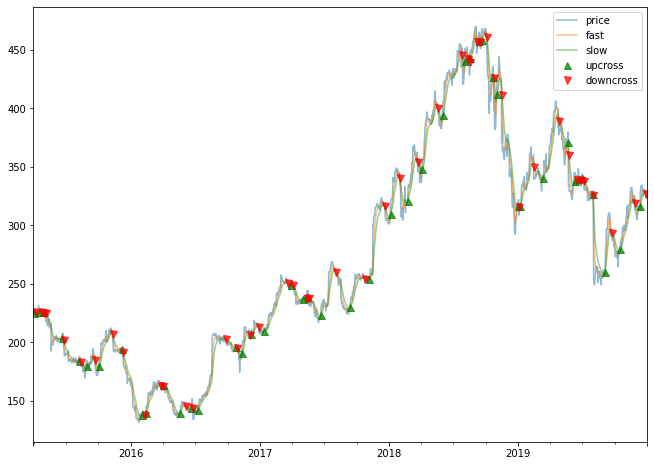

In [ ]:
def get_up_cross(df):
    crit1 = df.fast.shift(1) < df.slow.shift(1)
    crit2 = df.fast > df.slow
    return df.fast[(crit1) & (crit2)]

def get_down_cross(df):
    crit1 = df.fast.shift(1) > df.slow.shift(1)
    crit2 = df.fast < df.slow
    return df.fast[(crit1) & (crit2)]

up = get_up_cross(close_df)
down = get_down_cross(close_df)

f, ax = plt.subplots(figsize=(11,8))

close_df.loc['2014':].plot(ax=ax, alpha=.5)
up.loc['2014':].plot(ax=ax,ls='',marker='^', markersize=7,
                     alpha=0.75, label='upcross', color='g')
down.loc['2014':].plot(ax=ax,ls='',marker='v', markersize=7, 
                       alpha=0.75, label='downcross', color='r')

ax.legend()

In [ ]:
side_up = pd.Series(1, index=up.index)
side_down = pd.Series(-1, index=down.index)
side = pd.concat([side_up,side_down]).sort_index()
print(side)

2015-04-03    1
2015-04-08   -1
2015-04-15    1
2015-04-24   -1
2015-04-29    1
             ..
2019-09-24   -1
2019-10-17    1
2019-11-27   -1
2019-12-12    1
2019-12-29   -1
Length: 94, dtype: int64


In [ ]:
## standard cusum filter
def getTEvents(gRaw, h):
    tEvents, sPos, sNeg = [], 0, 0
    #diff = gRaw.diff().dropna()
    _idx = gRaw.index.searchsorted(gRaw.index - pd.Timedelta(days=1))
    diff = np.log(gRaw).diff()#.dropna()
    diff = diff[_idx>0]
    for i in tqdm(diff.index[1:]):
        pos, neg = float(sPos+diff.loc[i]), float(sNeg+diff.loc[i])
        sPos, sNeg=max(0., pos), min(0., neg)
        if sPos>h:
            sPos=0;tEvents.append(i)
        elif sNeg<-h:
            sNeg=0;tEvents.append(i)
    return pd.DatetimeIndex(tEvents)

def getEvents(close, tEvents, ptSl, trgt, minRet, numThreads, t1=False, side=None):
    #1) get target
    trgt = trgt.reindex(index = tEvents)
    trgt=trgt.loc[tEvents]
    print("Worked fine")
    #trgt=trgt[trgt>minRet] # minRet
    #2) get t1 (max holding period)
    if t1 is False:t1=pd.Series(pd.NaT, index=tEvents)
    #3) form events object, apply stop loss on t1
    if side is None:side_,ptSl_=pd.Series(1.,index=trgt.index), [ptSl[0],ptSl[0]]
    #else: side_,ptSl_=side.reindex(index=trgt.index).dropna(),ptSl[:2]
    else: 
      side_,ptSl_=side.reindex(index=trgt.index),ptSl[:2]
    events=(pd.concat({'t1':t1,'trgt':trgt,'side':side_}, axis=1)
            .dropna(subset=['trgt']))
    df0=mpPandasObj(func=applyPtSlOnT1,pdObj=('molecule',events.index),
                    numThreads=numThreads,close=close,events=events,
                    ptSl=ptSl_)
    events['t1']=df0.dropna(how='all').min(axis=1) # pd.min ignores nan
    if side is None:events=events.drop('side',axis=1)
    return events


def applyPtSlOnT1(close,events,ptSl,molecule):
     # apply stop loss/profit taking, if it takes place before t1 (end of event)
    #events_=events.loc[molecule]
    print("worked fine again")
    events_=events.reindex(index=molecule)
    out=events_[['t1']].copy(deep=True)
    if ptSl[0]>0: pt=ptSl[0]*events_['trgt']
    else: pt=pd.Series(index=events.index) # NaNs
    if ptSl[1]>0: sl=-ptSl[1]*events_['trgt']
    else: sl=pd.Series(index=events.index) # NaNs
    
    for loc,t1 in events_['t1'].fillna(close.index[-1]).iteritems():
        df0=close[loc:t1] # path prices
        df0=(df0/close[loc]-1)*events_.at[loc,'side'] # path returns
        out.loc[loc,'sl']=df0[df0<sl[loc]].index.min() # earliest stop loss
        out.loc[loc,'pt']=df0[df0>pt[loc]].index.min() # earliest profit taking
    return out   
    
def getBinsNew(events, close, t1=None):
    '''
    Compute event's outcome (including side information, if provided).
    events is a DataFrame where:
    -events.index is event's starttime
    -events['t1'] is event's endtime
    -events['trgt'] is event's target
    -events['side'] (optional) implies the algo's position side
    -t1 is original vertical barrier series
    Case 1: ('side' not in events): bin in (-1,1) <-label by price action
    Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    '''
    #1) prices aligned with events
    events_=events.dropna(subset=['t1'])
    px=events_.index.union(events_['t1'].values).drop_duplicates()
    px=close.reindex(px,method='bfill')
    #2) create out object
    out=pd.DataFrame(index=events_.index)
    out['ret']=px.loc[events_['t1'].values].values/px.loc[events_.index]-1
    if 'side' in events_:out['ret']*=events_['side'] # meta-labeling
    out['bin']=np.sign(out['ret'])
    
    if 'side' not in events_:
        # only applies when not meta-labeling
        # to update bin to 0 when vertical barrier is touched, we need the original
        # vertical barrier series since the events['t1'] is the time of first 
        # touch of any barrier and not the vertical barrier specifically. 
        # The index of the intersection of the vertical barrier values and the 
        # events['t1'] values indicate which bin labels needs to be turned to 0
        vtouch_first_idx = events[events['t1'].isin(t1.values)].index
        out.loc[vtouch_first_idx, 'bin'] = 0.
    
    if 'side' in events_:out.loc[out['ret']<=0,'bin']=0 # meta-labeling
    return out

In [ ]:
minRet = .01 
ptsl=[1,2]

from multiprocessing import cpu_count
cpus = cpu_count() - 1

dailyVol = getDailyVol(close_df['price'])
tEvents = getTEvents(close_df['price'],h=dailyVol.mean())
t1 = addVerticalBarrier(tEvents, close_df['price'], numDays=1)
ma_events = getEvents(close_df['price'],tEvents,ptsl,target,minRet,cpus,t1=t1,side=side)
print(ma_events)

100%|██████████| 1734/1734 [00:00<00:00, 20191.63it/s]


Worked fine
worked fine again
                   t1      trgt  side
2015-04-11 2015-04-12  0.169723   NaN
2015-04-15 2015-04-16  0.152157   1.0
2015-04-17 2015-04-18  0.173106   NaN
2015-05-05 2015-05-06  0.225941  -1.0
2015-05-09 2015-05-10  0.213112   NaN
...               ...       ...   ...
2019-11-26 2019-11-27  0.226913   NaN
2019-12-03 2019-12-04  0.263384   NaN
2019-12-06 2019-12-07  0.275873   NaN
2019-12-12 2019-12-13  0.289142   1.0
2019-12-20 2019-12-21  0.279702   NaN

[346 rows x 3 columns]


In [ ]:
ma_events.side.value_counts()

-1.0    17
 1.0    16
Name: side, dtype: int64

In [ ]:
ma_side = ma_events.dropna().side
ma_side

In [ ]:
ma_bins = getBinsNew(ma_events,close_df['price'], t1).dropna()
print(ma_bins)

In [ ]:
Xx = pd.merge_asof(ma_bins, side.to_frame().rename(columns={0:'side'}),
                   left_index=True, right_index=True, direction='forward')
print(Xx)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report
RANDOM_STATE = 777


In [ ]:
X = ma_side.values.reshape(-1,1)
#X = Xx.side.values.reshape(-1,1)
y = ma_bins.bin.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    shuffle=False)

print(X_train, y_train)

              precision    recall  f1-score   support

         0.0       0.47      1.00      0.64         8
         1.0       0.00      0.00      0.00         9

    accuracy                           0.47        17
   macro avg       0.24      0.50      0.32        17
weighted avg       0.22      0.47      0.30        17



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


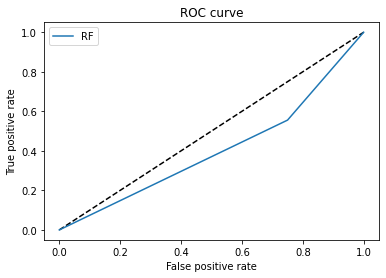

In [ ]:


n_estimator = 10000
rf = RandomForestClassifier(max_depth=2, n_estimators=n_estimator,
                            criterion='entropy', random_state=RANDOM_STATE)
rf.fit(X_train, y_train)

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Weights

In [ ]:
## https://github.com/chrisconlan/algorithmic-trading-with-python/blob/1f615f488a3faa6274a701afccfcf977dfa83570/src/pypm/weights.py
import numpy as np
import pandas as pd
from scipy.stats import hmean

def calculate_uniqueness(event_spans: pd.Series, price_index: pd.Series) -> pd.Series:
    """
    event_spans is a series with an index of start dates and values of end dates
    of a label.
    price_index is an index of underlying dates for the event
    Returns a series of uniqueness values that can be used as weights, indexed 
    as the event start dates. Weights may need to be standardized again before 
    training.
    """

    # Create a binary dataframe 
    # value is 1 during event span and 0 otherwise
    columns = range(event_spans.shape[0])
    df = pd.DataFrame(0, index=price_index, columns=columns)

    for i, (event_start, event_end) in enumerate(event_spans.items()):
        df[i].loc[event_start:event_end] += 1

    # Compute concurrency over event span then calculate uniqueness
    avg_uniquenesses = list()
    for i, (event_start, event_end) in enumerate(event_spans.items()):
        concurrency: pd.Series = df.loc[event_start:event_end].sum(axis=1)
        avg_uniqueness = 1 / hmean(concurrency)
        avg_uniquenesses.append(avg_uniqueness)

    return pd.Series(avg_uniquenesses, index=event_spans.index)

  
def calculate_weights(event_spans: pd.Series, price_index: pd.Series) -> pd.Series:
    return calculate_uniqueness(event_spans, price_index)

In [ ]:
#event_labels, event_spans = calculate_labels(close, event_index)

weights = calculate_weights(event_spans, close.index)


In [ ]:
def calculate_simple_moving_average(series: pd.Series, n: int=20) -> pd.Series:
    """Calculates the simple moving average"""
    return series.rolling(n).mean()


def calculate_simple_moving_sample_stdev(series: pd.Series, n: int=20) -> pd.Series:
    """Calculates the simple moving average"""
    return series.rolling(n).std()

def calculate_log_return_series(series: pd.Series) -> pd.Series:
    """
    Same as calculate_return_series but with log returns
    """
    shifted_series = series.shift(1, axis=0)
    return pd.Series(np.log(series / shifted_series))


_calc_delta = calculate_non_uniform_lagged_change
_calc_ma = calculate_simple_moving_average
_calc_log_return = calculate_log_return_series

def _calc_rolling_vol(series, n):
    return series.rolling(n).std() * np.sqrt(252 / n)

def calculate_features(price_series, revenue_series) -> pd.DataFrame:
    """
    Calculate any and all potentially useful features. Return as a dataframe.
    """

    log_revenue = np.log(revenue_series)
    log_prices = np.log(price_series)

    log_revenue_ma = _calc_ma(log_revenue, 10)
    log_prices_ma = _calc_ma(log_prices, 10)

    log_returns = _calc_log_return(price_series)

    features_by_name = dict()

    for i in [7, 30, 90, 180, 360]:

        rev_feature = _calc_delta(log_revenue_ma, i)
        price_feature = _calc_delta(log_prices_ma, i)
        vol_feature = _calc_rolling_vol(log_returns, i)

        features_by_name.update({
            f'{i}_day_revenue_delta': rev_feature,
            f'{i}_day_return': price_feature,
            f'{i}_day_vol': vol_feature,
        })

    features_df = pd.DataFrame(features_by_name)    
    return features_df

In [ ]:
revenue_series = awu_alt.value
price_series=awu_eod.close
features_df = calculate_features(price_series, revenue_series)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [ ]:
features_df.tail()

,7_day_revenue_delta,7_day_return,7_day_vol,30_day_revenue_delta,30_day_return,30_day_vol,90_day_revenue_delta,90_day_return,90_day_vol,180_day_revenue_delta,180_day_return,180_day_vol,360_day_revenue_delta,360_day_return,360_day_vol
date,,,,,,,,,,,,,,,
2019-12-24,0.006010,0.026270,0.073760,0.019417,0.012935,0.046668,0.049910,0.096116,0.030863,0.102029,-0.032083,0.030059,-0.113051,0.053401,0.020970
2019-12-26,0.005577,0.018070,0.068822,0.020280,0.019746,0.046697,0.012849,0.114193,0.030894,0.103517,-0.030665,0.029978,-0.107165,0.058042,0.020971
2019-12-27,-0.019436,0.015026,0.070837,0.003551,0.021306,0.047114,-0.005271,0.123274,0.030665,0.088142,-0.031161,0.029942,-0.112640,0.055510,0.020894
2019-12-30,-0.049284,0.007775,0.065048,-0.040252,0.030498,0.044671,-0.035026,0.131376,0.030649,0.079554,-0.030299,0.029943,-0.145081,0.057743,0.020828
2019-12-31,-0.067621,0.000667,0.075593,-0.068750,0.028968,0.045319,-0.068539,0.138136,0.030726,0.072449,-0.030011,0.029973,-0.164144,0.052612,0.020839


In [ ]:
# https://github.com/chrisconlan/algorithmic-trading-with-python/blob/1f615f488a3faa6274a701afccfcf977dfa83570/listings/chapter_3/3_7_example_signals.py

def create_macd_signal(series: pd.Series, n1: int=5, n2: int=34) -> pd.Series:
    """
    Create a momentum-based signal based on the MACD crossover principle. 
    Generate a buy signal when the MACD cross above zero, and a sell signal when
    it crosses below zero.
    """

    # Calculate the macd and get the signs of the values.
    macd = calculate_macd_oscillator(series, n1, n2)
    macd_sign = np.sign(macd)

    # Create a copy shifted by some amount.
    macd_shifted_sign = macd_sign.shift(1, axis=0)

    # Multiply by the sign by the boolean. This will have the effect of casting
    # the boolean to an integer (either 0 or 1) and then multiply by the sign
    # (either -1, 0 or 1).
    return macd_sign * (macd_sign != macd_shifted_sign)


def create_bollinger_band_signal(series: pd.Series, n: int=20) -> pd.Series:
    """
    Create a reversal-based signal based on the upper and lower bands of the 
    Bollinger bands. Generate a buy signal when the price is below the lower 
    band, and a sell signal when the price is above the upper band.
    """
    bollinger_bands = calculate_bollinger_bands(series, n)
    sell = series > bollinger_bands['upper']
    buy = series < bollinger_bands['lower']
    return (1*buy - 1*sell)